# License Plate Readability Enhancement

This notebook demonstrates a complete pipeline for enhancing the readability of pre-cropped car license plate images using OpenCV. The goal is to improve the visual clarity of license plate characters for further processing (e.g., OCR, not included here).

## 1. Imports and Utility Functions
Import required libraries and define helper functions for image display.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image(image, title="Image", cmap_override=None):
    plt.figure(figsize=(6, 4))
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray' if cmap_override == 'gray' or cmap_override is None else cmap_override)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def display_images_subplot(images_dict, cols=2, fig_size=(15, 10)):
    images = list(images_dict.values())
    titles = list(images_dict.keys())
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=fig_size)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


from sklearn.decomposition import PCA

def pca_denoise(image, n_components=0.95):
    # Flatten image to 2D (rows, cols)
    original_shape = image.shape
    flat = image.reshape(-1, 1)
    pca = PCA(n_components=n_components, svd_solver='auto')
    transformed = pca.fit_transform(flat)
    restored = pca.inverse_transform(transformed)
    return restored.reshape(original_shape).astype(np.uint8)

    

## 2. Load Pre-cropped License Plate Image
Load the license plate image. Update the path to your image file as needed.

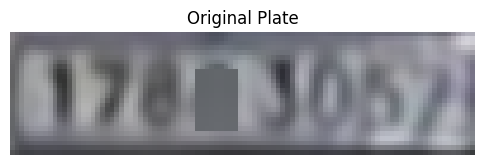

In [ ]:
plate_image_path = r"C:\Users\Admin\Downloads\Realistic License Plate Restoration and Recognition Dataset (RLPR)\Realistic License Plate Restoration and Recognition Dataset (RLPR)\Dataset\sample_001" 
original_plate_image = cv2.imread(plate_image_path)
if original_plate_image is None:
    print(f"Error: Could not load image at {plate_image_path}")
else:
    display_image(original_plate_image, title="Original Plate")

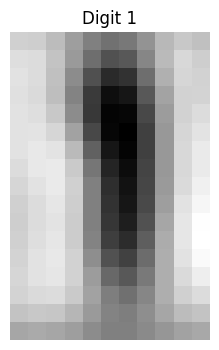

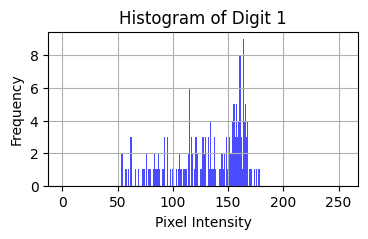

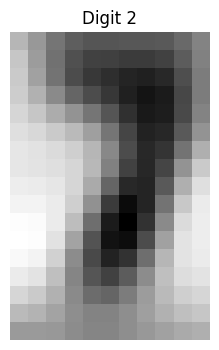

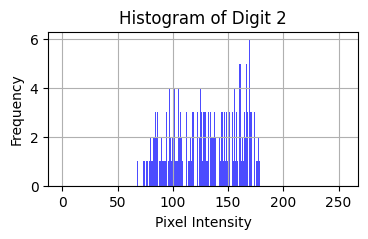

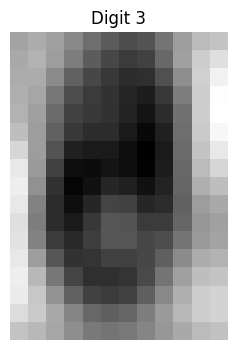

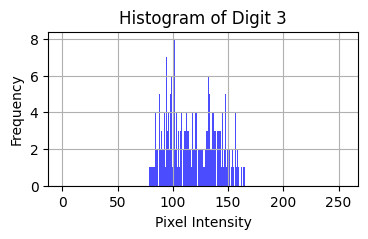

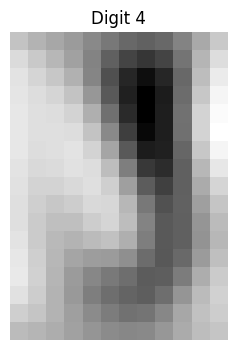

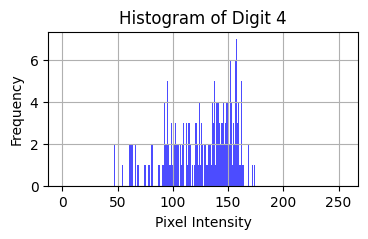

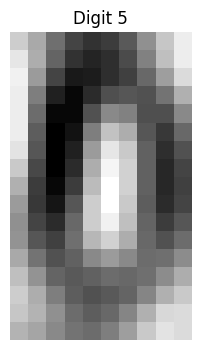

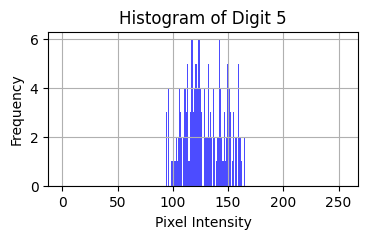

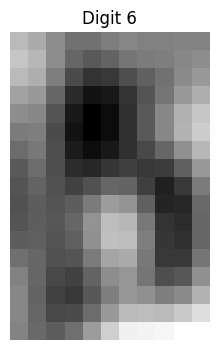

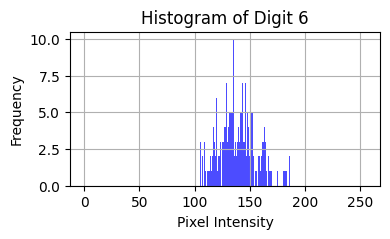

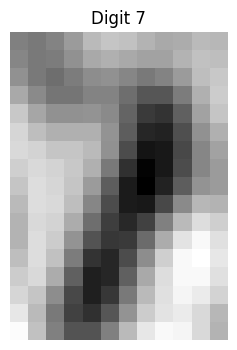

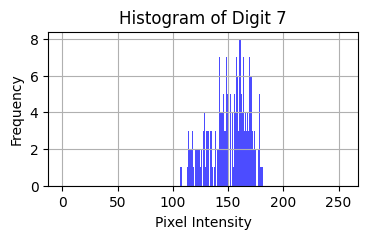

In [166]:
# Example: Split plate into 7 regions (3 digits, block, 4 digits)
digit_boxes = [
    (5, 5, 16, 22),   # Digit 1
    (15, 5, 26, 22),  # Digit 2
    (26, 5, 38, 22),  # Digit 3
    # (39, 0, 53, 26),  # Block (skip this one)
    (50, 5, 62, 22),  # Digit 4
    (62, 5, 72, 22),  # Digit 5
    (72, 5, 83, 22),  # Digit 6
    (83, 5, 95, 22),  # Digit 7
]
# Assuming digit_boxes and original_plate_image are already defined

for i, (x1, y1, x2, y2) in enumerate(digit_boxes):
    digit_img = original_plate_image[y1:y2, x1:x2]
    #Convert to grayscale if needed
    if len(digit_img.shape) == 3:
        digit_gray = cv2.cvtColor(digit_img, cv2.COLOR_BGR2GRAY)
    else:
        digit_gray = digit_img.copy()
    # Show digit

    ## histogram equalization
    # digit_gray = cv2.equalizeHist(digit_gray)
    display_image(digit_gray, title=f"Digit {i+1}")
    # Show histogram
    plt.figure(figsize=(4,2))
    plt.hist(digit_gray.ravel(), bins=256, range=(0,255), color='blue', alpha=0.7)
    plt.title(f"Histogram of Digit {i+1}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

OCR result on Original : 
OCR result on Gray+Tophat-Blackhat : 
OCR result on Sharpened : 
OCR result on Sobel : 
OCR result on Adaptive Threshold : 


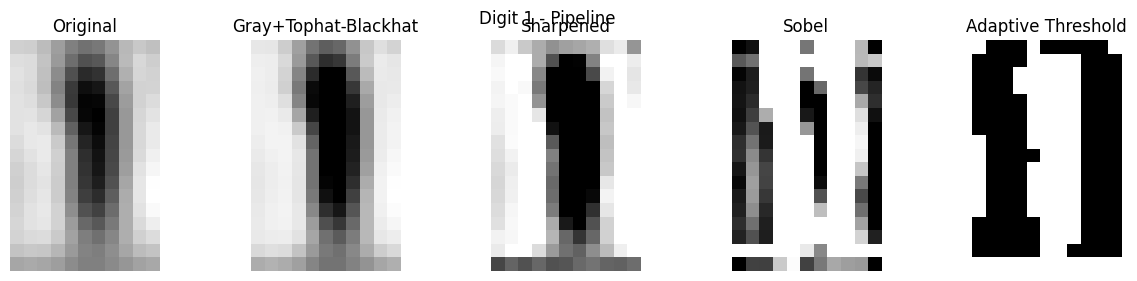

OCR result on Original : 7
OCR result on Gray+Tophat-Blackhat : 7
OCR result on Sharpened : 7
OCR result on Sobel : 
OCR result on Adaptive Threshold : 


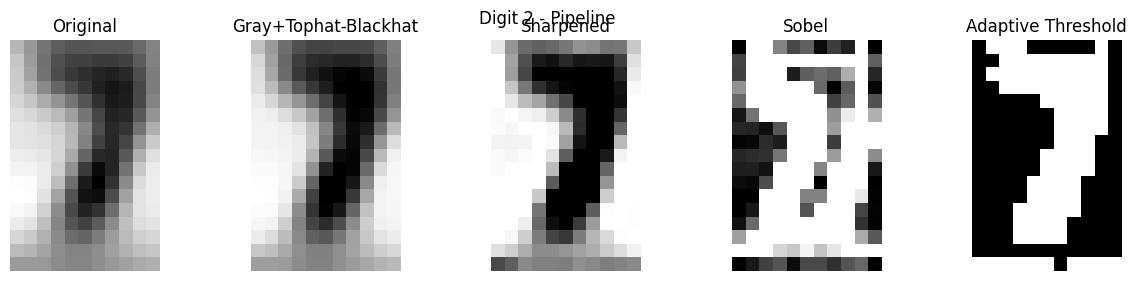

OCR result on Original : 
OCR result on Gray+Tophat-Blackhat : 
OCR result on Sharpened : 6
OCR result on Sobel : 
OCR result on Adaptive Threshold : .


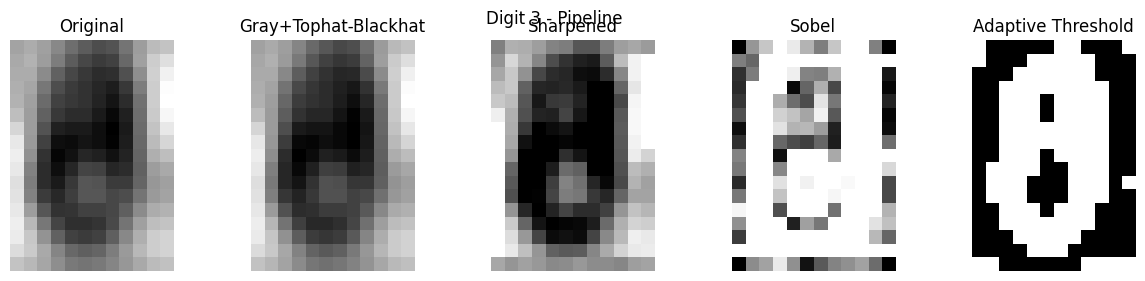

OCR result on Original : 
OCR result on Gray+Tophat-Blackhat : 
OCR result on Sharpened : 
OCR result on Sobel : 
OCR result on Adaptive Threshold : 


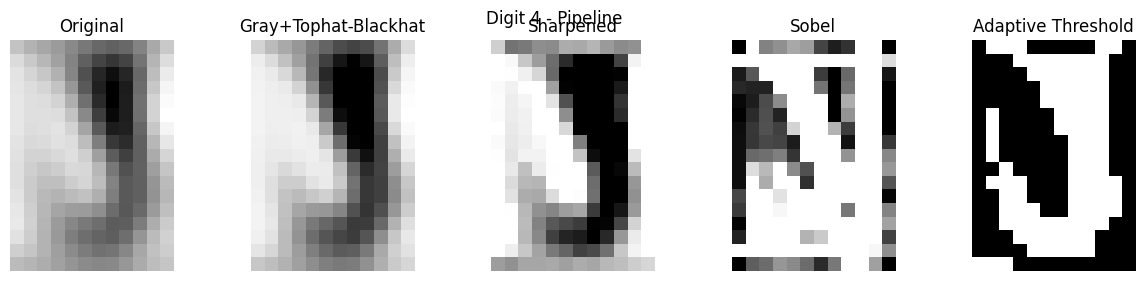

OCR result on Original : 
OCR result on Gray+Tophat-Blackhat : 
OCR result on Sharpened : 
OCR result on Sobel : 
OCR result on Adaptive Threshold : 


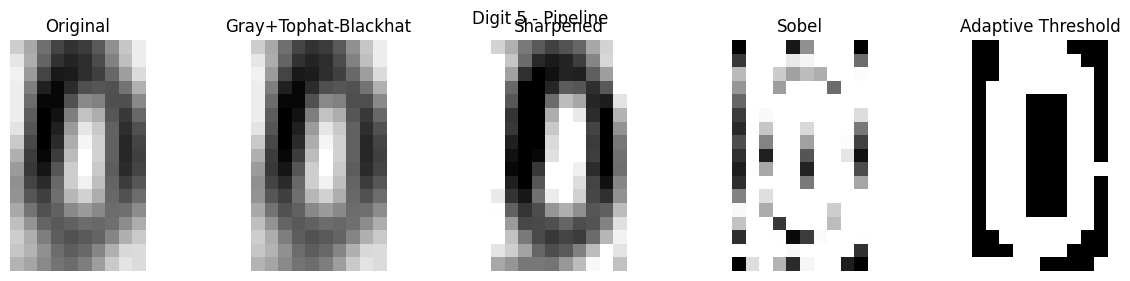

OCR result on Original : .
OCR result on Gray+Tophat-Blackhat : 
OCR result on Sharpened : 
OCR result on Sobel : 
OCR result on Adaptive Threshold : 


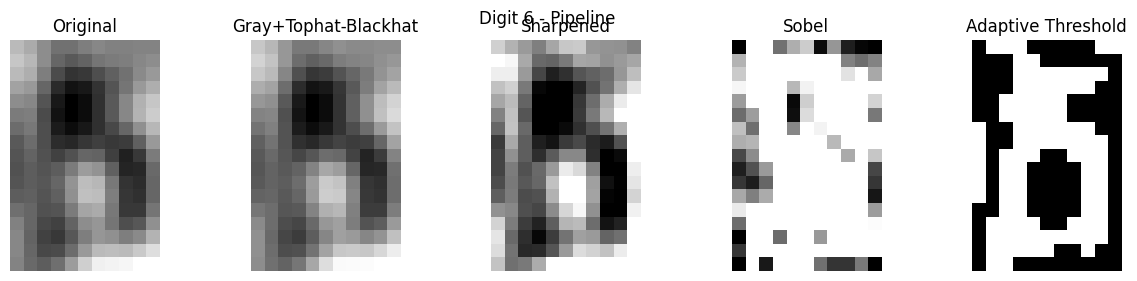

OCR result on Original : 
OCR result on Gray+Tophat-Blackhat : 
OCR result on Sharpened : 
OCR result on Sobel : 
OCR result on Adaptive Threshold : 2.


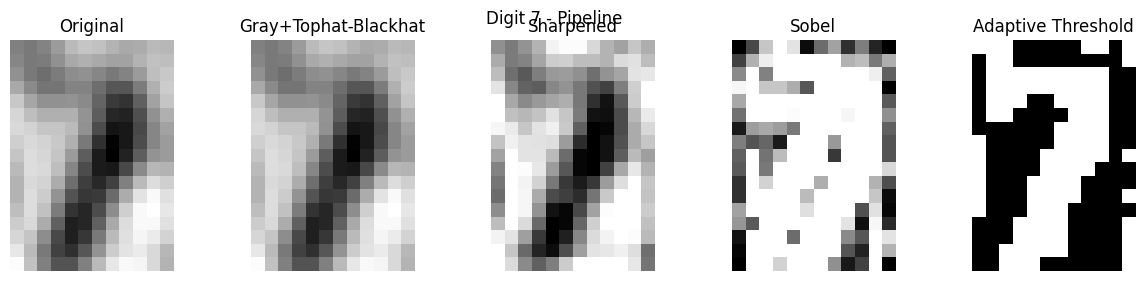

In [189]:
import pytesseract
for i, (x1, y1, x2, y2) in enumerate(digit_boxes):
    digit_img = original_plate_image[y1:y2, x1:x2]
    if len(digit_img.shape) == 3:
        digit_gray = cv2.cvtColor(digit_img, cv2.COLOR_BGR2GRAY)
    else:
        digit_gray = digit_img.copy()

    steps = {}
    steps['Original'] = digit_gray

    # Top-hat and Black-hat
    kernel = np.ones((50, 50), np.uint8)
    tophat = cv2.morphologyEx(digit_gray, cv2.MORPH_TOPHAT, kernel)
    blackhat = cv2.morphologyEx(digit_gray, cv2.MORPH_BLACKHAT, kernel)
    gray_tophat_blackhat = cv2.add(digit_gray, tophat)
    gray_tophat_blackhat = cv2.subtract(gray_tophat_blackhat, blackhat)
    steps['Gray+Tophat-Blackhat'] = gray_tophat_blackhat

    # Sharpen
    sharpening_kernel = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    sharpened = cv2.filter2D(gray_tophat_blackhat, -1, sharpening_kernel)
    steps['Sharpened'] = sharpened

    # sobel
    sobel_x = cv2.Sobel(sharpened, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(sharpened, cv2.CV_64F, 0, 1, ksize=3)
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_magnitude = np.uint8(np.clip(sobel_magnitude, 0, 255))
    steps['Sobel'] = sobel_magnitude


    # adaptive Thresholding
    adaptive_threshold = cv2.adaptiveThreshold(sharpened, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    steps['Adaptive Threshold'] = adaptive_threshold


    # Show all steps for this digit in a subplot
    n = len(steps)
    plt.figure(figsize=(3 * n, 3))
    for j, (step_name, img) in enumerate(steps.items()):
        plt.subplot(1, n, j + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(step_name)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        ocr_final = pytesseract.image_to_string(img, config='--psm 6 outputbase digits')
        print("OCR result on "+step_name+' :', ocr_final.strip())
    plt.suptitle(f"Digit {i+1} - Pipeline")
    plt.show()

# OCR



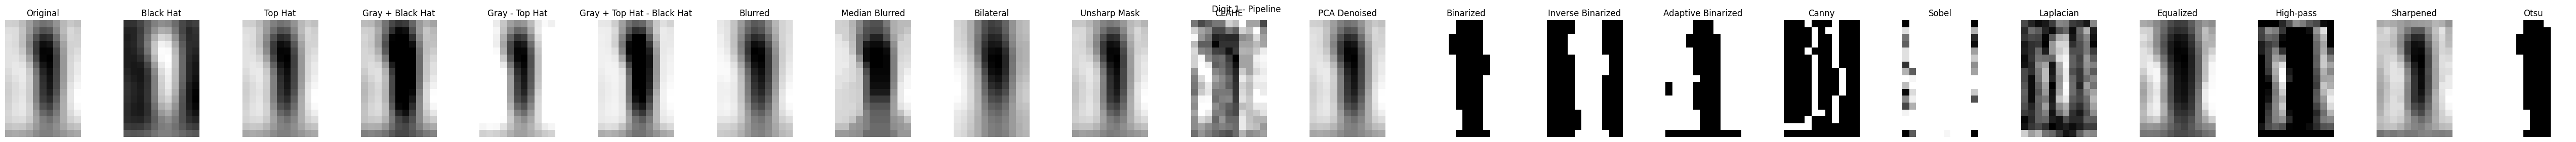

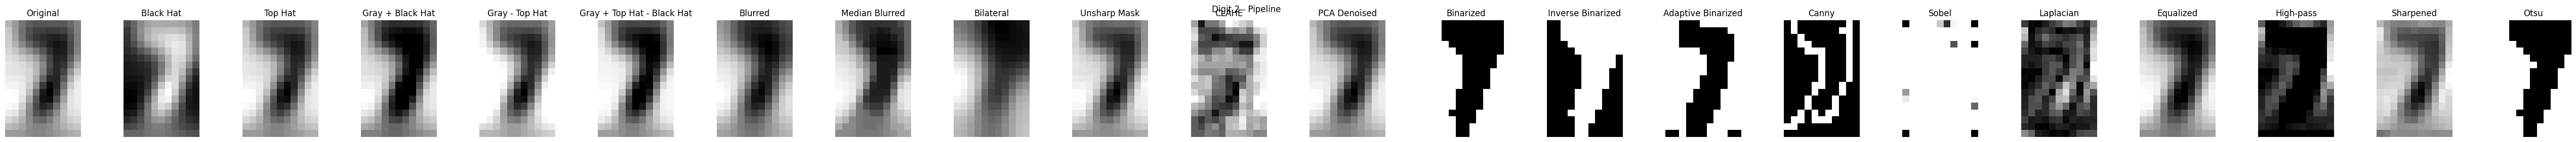

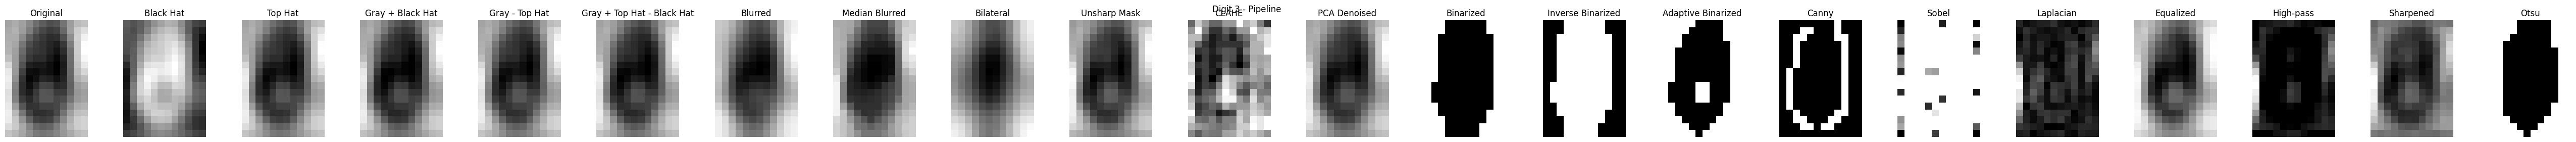

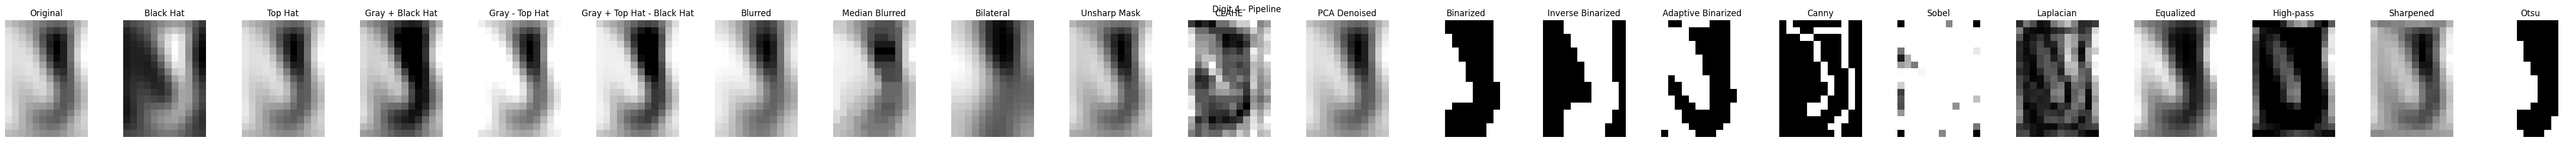

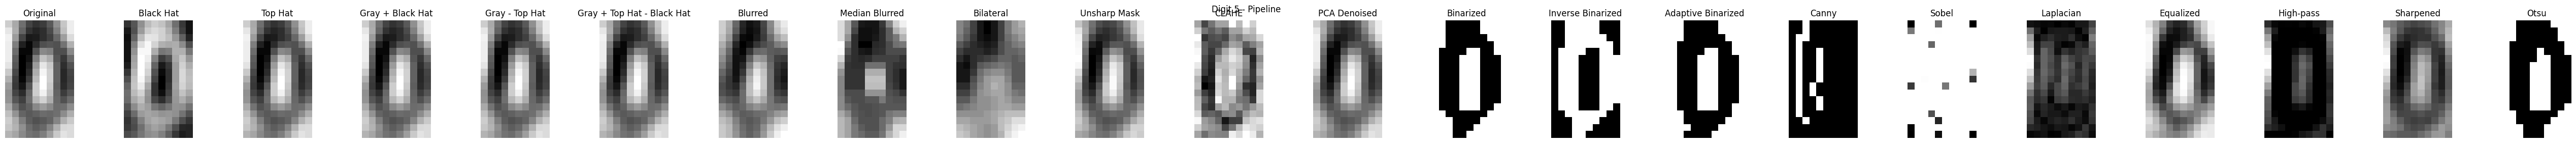

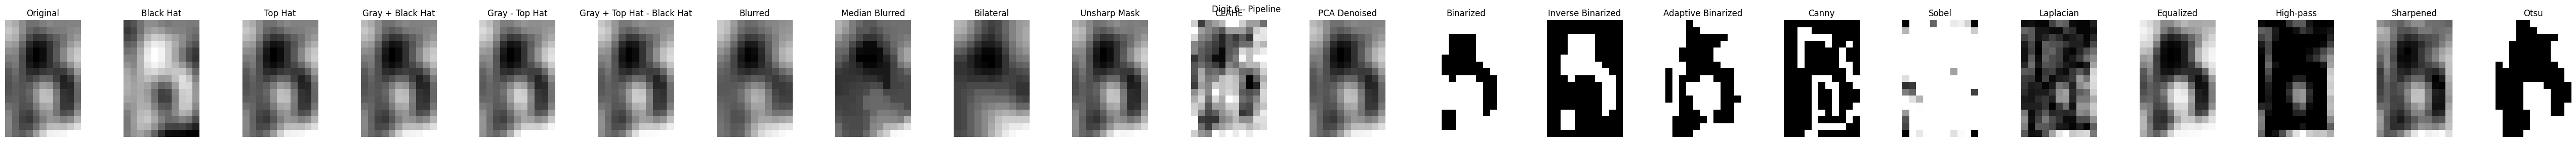

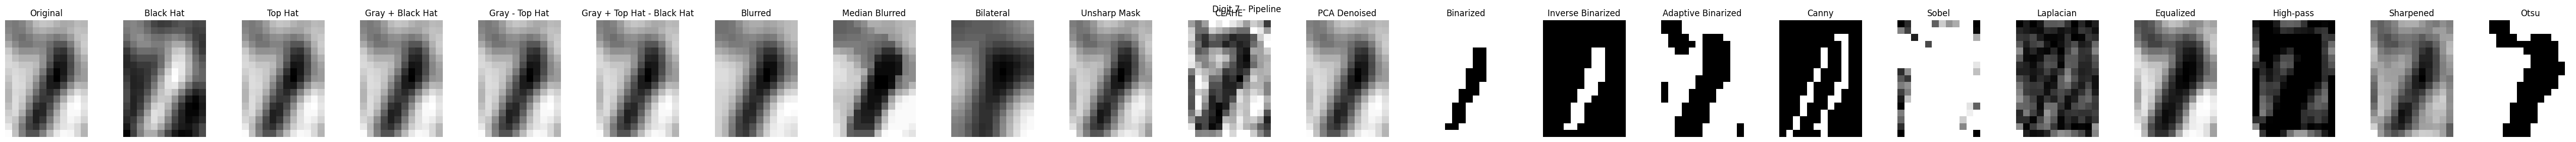

In [172]:
for i, (x1, y1, x2, y2) in enumerate(digit_boxes):
    digit_img = original_plate_image[y1:y2, x1:x2]
    if len(digit_img.shape) == 3:
        digit_gray = cv2.cvtColor(digit_img, cv2.COLOR_BGR2GRAY)
    else:
        digit_gray = digit_img.copy()
    
    steps = {}
    steps['Original'] = digit_gray
    ## black hat , top hat, and closing
    kernel = np.ones((50, 50), np.uint8)
    digit_blackhat = cv2.morphologyEx(digit_gray, cv2.MORPH_BLACKHAT, kernel)
    digit_tophat = cv2.morphologyEx(digit_gray, cv2.MORPH_TOPHAT, kernel)
    steps['Black Hat'] = digit_blackhat
    steps['Top Hat'] = digit_tophat
    
    ## gray - black hat
    digit_blackhat_sub = cv2.subtract(digit_gray, digit_blackhat) 
    steps['Gray + Black Hat'] = digit_blackhat_sub
    ## gray + top hat
    digit_tophat_sub = cv2.add(digit_gray, digit_tophat)
    steps['Gray - Top Hat'] = digit_tophat_sub
    # gray + top hat - black hat
    digit_tophat_blackhat_sub = cv2.subtract(digit_tophat_sub, digit_blackhat)
    steps['Gray + Top Hat - Black Hat'] = digit_tophat_blackhat_sub
    # Gaussian Blur
    digit_blurred = cv2.GaussianBlur(digit_gray, (5, 5), 0)
    steps['Blurred'] = digit_blurred
    # Median Blur
    digit_median_blurred = cv2.medianBlur(digit_gray, 5)
    steps['Median Blurred'] = digit_median_blurred
    # Bilateral Filter
    digit_bilateral = cv2.bilateralFilter(digit_gray, 9, 75, 75)
    steps['Bilateral'] = digit_bilateral
    # Unsharp Masking
    digit_unsharp = cv2.addWeighted(digit_gray, 1.5, digit_blurred, -0.5, 0)
    steps['Unsharp Mask'] = digit_unsharp
    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    digit_clahe = clahe.apply(digit_gray)
    steps['CLAHE'] = digit_clahe
    # PCA Denoising
    digit_pca_denoised = pca_denoise(digit_gray, n_components=0.95)
    steps['PCA Denoised'] = digit_pca_denoised
    # Binarization
    _, digit_binary = cv2.threshold(digit_gray, 127, 255, cv2.THRESH_BINARY)
    steps['Binarized'] = digit_binary
    # Inverse Binarization
    _, digit_binary_inv = cv2.threshold(digit_gray, 127, 255, cv2.THRESH_BINARY_INV)
    steps['Inverse Binarized'] = digit_binary_inv
    # Adaptive Binarization
    digit_adaptive_binary = cv2.adaptiveThreshold(digit_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                    cv2.THRESH_BINARY, 11, 2)
    steps['Adaptive Binarized'] = digit_adaptive_binary
    # Canny Edge Detection
    digit_canny = cv2.Canny(digit_gray, 100, 200)
    steps['Canny'] = digit_canny
    # Sobel Edge Detection
    sobel_x = cv2.Sobel(digit_gray, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(digit_gray, cv2.CV_64F, 0, 1, ksize=5)
    digit_sobel = cv2.magnitude(sobel_x, sobel_y)
    digit_sobel = cv2.convertScaleAbs(digit_sobel)
    steps['Sobel'] = digit_sobel
    # Laplacian Edge Detection
    digit_laplacian = cv2.Laplacian(digit_gray, cv2.CV_64F)
    digit_laplacian = cv2.convertScaleAbs(digit_laplacian)
    steps['Laplacian'] = digit_laplacian


    # Histogram Equalization
    digit_eq = cv2.equalizeHist(digit_gray)
    steps['Equalized'] = digit_eq

    # High-pass filter
    high_pass_kernel = np.array([[-1, -1, -1],
                                 [-1,  8, -1],
                                 [-1, -1, -1]])
    digit_highpass = cv2.filter2D(digit_gray, -1, high_pass_kernel)
    digit_highpass_norm = cv2.normalize(digit_highpass, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    steps['High-pass'] = digit_highpass_norm

    # Sharpening
    sharpening_kernel = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    digit_sharp = cv2.filter2D(digit_gray, -1, sharpening_kernel)
    steps['Sharpened'] = digit_sharp

    # Otsu Thresholding
    _, digit_otsu = cv2.threshold(digit_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    steps['Otsu'] = digit_otsu

# Show all steps for this digit in a subplot
    n = len(steps)
    plt.figure(figsize=(3 * n, 3))
    for j, (step_name, img) in enumerate(steps.items()):
        plt.subplot(1, n, j + 1)
        plt.imshow(img, cmap='gray')
        plt.title(step_name)
        plt.axis('off')
    plt.suptitle(f"Digit {i+1} - Pipeline")
    plt.show()

## 3. License Plate Enhancement Pipeline
Apply a series of enhancement steps to improve the readability of the license plate.

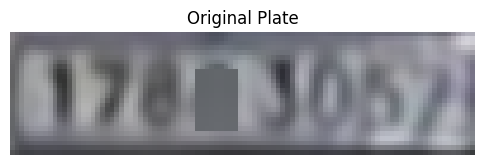

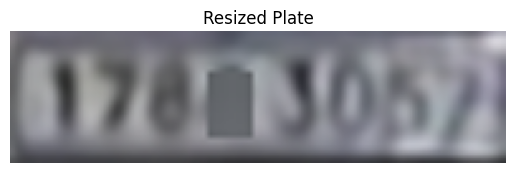

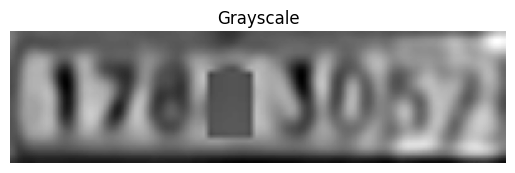

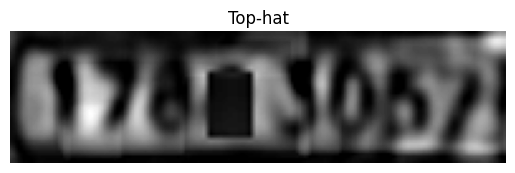

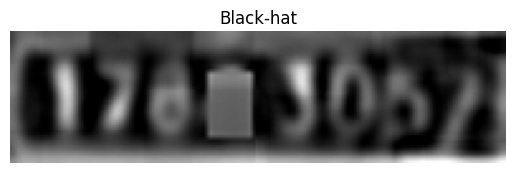

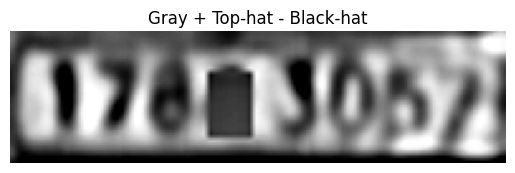

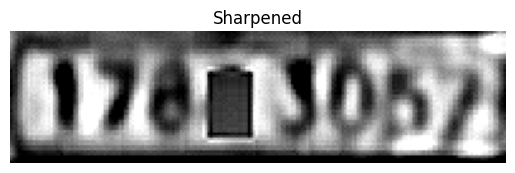

OCR result on original image: 1788308
OCR result: 17883057



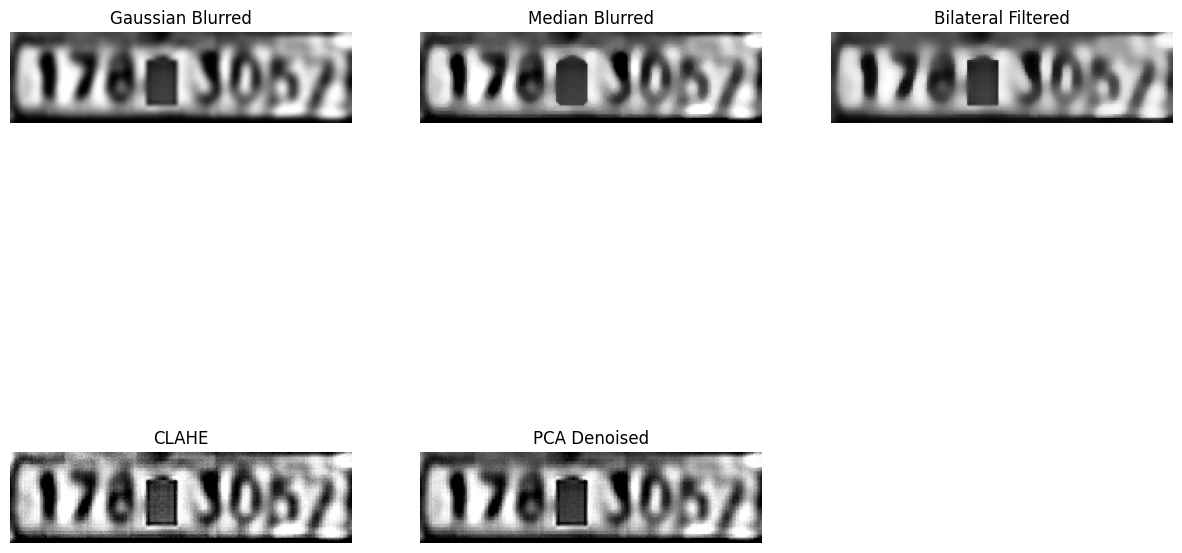

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

plate_image_path = r"C:\Users\Admin\Desktop\TD_INFO\Traitement image\SR_ROI.png" 
original_plate_image = cv2.imread(plate_image_path)
if original_plate_image is None:
    print(f"Error: Could not load image at {plate_image_path}")
else:
    display_image(original_plate_image, title="Original Plate")


# Set the path to the Tesseract executable
# Update the path below if your tesseract is installed elsewhere
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# 1. Resize up (e.g., 2x)
scale = 2
h, w = original_plate_image.shape[:2]
plate_up = cv2.resize(original_plate_image, (w*scale, h*scale), interpolation=cv2.INTER_CUBIC)
plt.figure(); plt.imshow(cv2.cvtColor(plate_up, cv2.COLOR_BGR2RGB)); plt.title("Resized Plate"); plt.axis('off'); plt.show()

# 2. Grayscale
gray = cv2.cvtColor(plate_up, cv2.COLOR_BGR2GRAY)
plt.figure(); plt.imshow(gray, cmap='gray'); plt.title("Grayscale"); plt.axis('off'); plt.show()

# 3. Top-hat and Black-hat, then combine
kernel = np.ones((25, 25), np.uint8)
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
plt.figure(); plt.imshow(tophat, cmap='gray'); plt.title("Top-hat"); plt.axis('off'); plt.show()
plt.figure(); plt.imshow(blackhat, cmap='gray'); plt.title("Black-hat"); plt.axis('off'); plt.show()

enhanced = cv2.add(gray, tophat)
enhanced = cv2.subtract(enhanced, blackhat)
plt.figure(); plt.imshow(enhanced, cmap='gray'); plt.title("Gray + Top-hat - Black-hat"); plt.axis('off'); plt.show()

# 4. Sharpen
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
sharpened = cv2.filter2D(enhanced, -1, sharpen_kernel)
plt.figure(); plt.imshow(sharpened, cmap='gray'); plt.title("Sharpened"); plt.axis('off'); plt.show()

# 5. All types of Denoising
blurred = cv2.GaussianBlur(sharpened, (5, 5), 0)
median_blurred = cv2.medianBlur(sharpened, 5)
bilateral = cv2.bilateralFilter(sharpened, 9, 75, 75)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(sharpened)
pca_denoised = pca_denoise(sharpened, n_components=0.95)
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1); plt.imshow(blurred, cmap='gray'); plt.title("Gaussian Blurred"); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(median_blurred, cmap='gray'); plt.title("Median Blurred"); plt.axis('off')
plt.subplot(2, 3, 3); plt.imshow(bilateral, cmap='gray'); plt.title("Bilateral Filtered"); plt.axis('off')
plt.subplot(2, 3, 4); plt.imshow(clahe_img, cmap='gray'); plt.title("CLAHE"); plt.axis('off')
plt.subplot(2, 3, 5); plt.imshow(pca_denoised, cmap='gray'); plt.title("PCA Denoised"); plt.axis('off')

# ocr original

# 5. OCR with digit whitelist
img_for_ocr = cv2.cvtColor(pca_denoised, cv2.COLOR_GRAY2RGB)
config = '--psm 7 -c tessedit_char_whitelist=0123456789'
ocr_original = pytesseract.image_to_string(original_plate_image, config=config)
ocr_result = pytesseract.image_to_string(img_for_ocr, config=config)
print("OCR result on original image:", ocr_original.strip())
print("OCR result:", ocr_result)
